# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/MyDrive/Polimi/ANNDL/challenge2

Mounted at /gdrive
/gdrive/MyDrive/Polimi/ANNDL/challenge2


## ⚙️ Import Libraries

In [2]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

from datetime import datetime
import pandas as pd

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## ⏳ Load the Data

In [3]:
data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

# Separiamo il train set in training e validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42  # 20% per il validation set
)

# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
###
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

print(f"Training X shape: {X_train.shape}")
print(f"Validation X shape: {X_val.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2092, 64, 128, 1)
Validation X shape: (523, 64, 128, 1)
Training y shape: (2092, 64, 128)
Test X shape: (10022, 64, 128, 1)


In [4]:
category_map = {
  0: 0, #Background
  1: 1, #Soil
  2: 2, #Bedrock
  3: 3, #Sand
  4: 4, #Big Rock
}

In [5]:
def visualize_image_label_pairs(X, y, num_images, class_names, reverse=0):
    """
    Visualize pairs of original images and their corresponding label overlays,
    and add a color legend for the labels.

    Args:
        X: Array of images (shape: [num_samples, height, width, channels]).
        y: Array of labels (shape: [num_samples, height, width]).
        num_images: Number of image-label pairs to visualize.
        class_names: List of class names (optional). If provided, a legend will be added.
    """

    if reverse == 1:
        X = X[::-1]
        y = y[::-1]

    # Set up the grid layout: 2 columns, num_images rows
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

    # Define a custom colormap for the legend
    if class_names is not None:
        cmap = mcolors.ListedColormap(plt.cm.jet(np.linspace(0, 1, len(class_names))))
        norm = mcolors.BoundaryNorm(np.arange(len(class_names)+1), len(class_names))
    else:
        cmap = 'jet'
        norm = None

    for i in range(num_images):
        # Extract the image and its corresponding label
        image = X[i]
        label = y[i]

        # Show the original image in the first column
        ax = axes[i, 0] if num_images > 1 else axes[0]
        ax.imshow(image.squeeze(), cmap='gray')  # Use squeeze for grayscale images
        ax.axis('off')
        ax.set_title(f"Image {i+1}")

        # Show the image with the label overlay in the second column
        ax = axes[i, 1] if num_images > 1 else axes[1]
        ax.imshow(image.squeeze(), cmap='gray')  # Background: original image
        ax.imshow(label, alpha=0.5, cmap=cmap, norm=norm)  # Label overlay
        ax.axis('off')
        ax.set_title(f"Label Overlay {i+1}")

    # Add the legend if class names are provided
    if class_names is not None:
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(len(class_names))]
        plt.legend(handles, class_names, title="Class Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

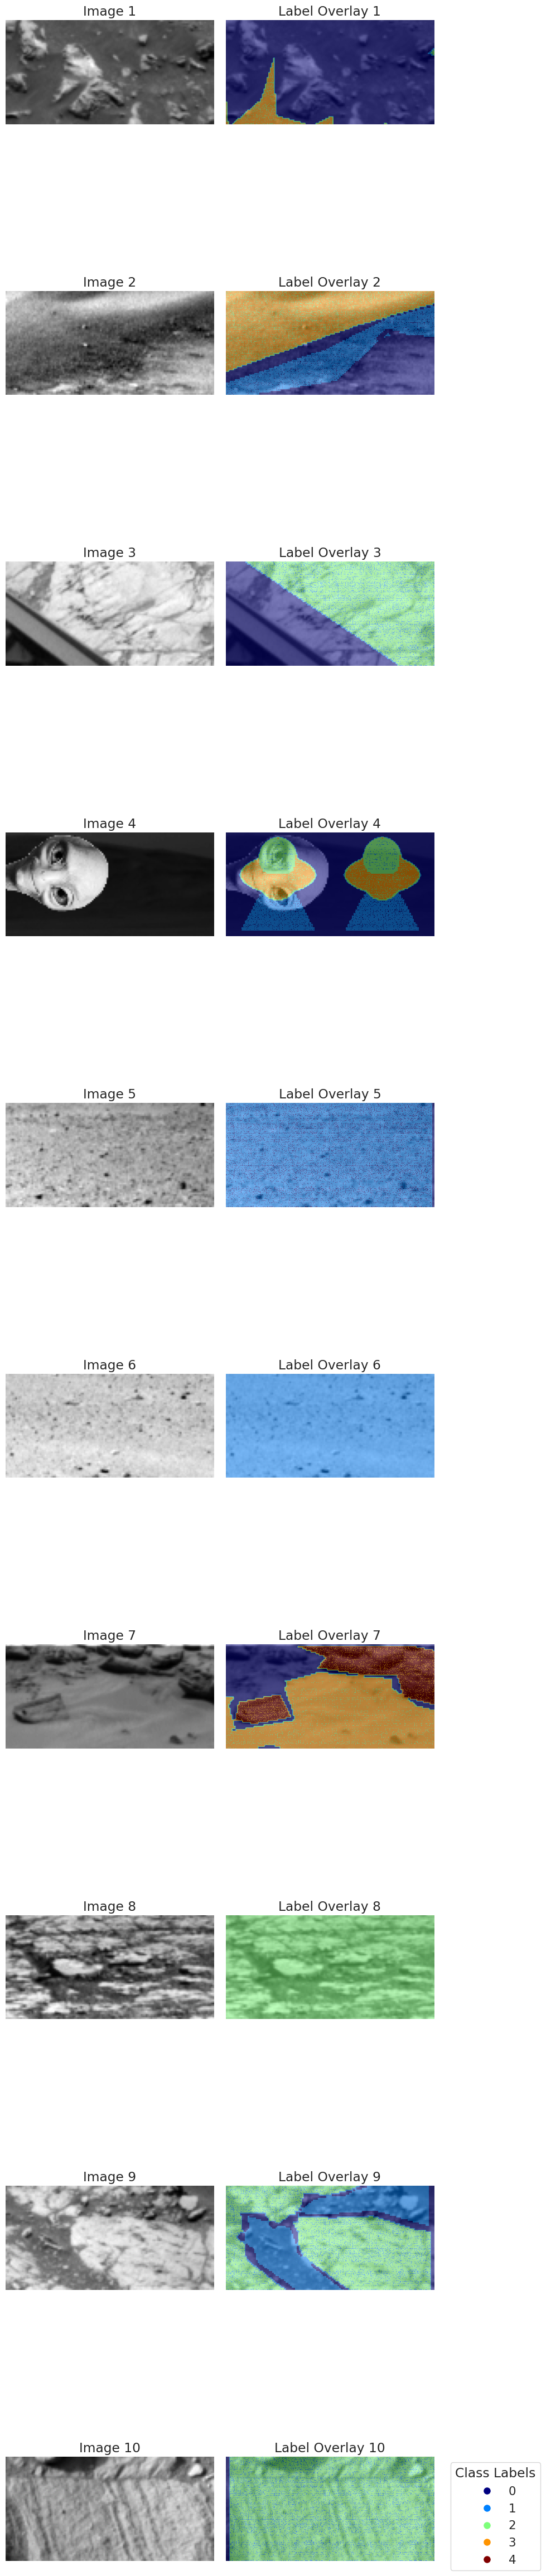

In [6]:
visualize_image_label_pairs(X_train, y_train, num_images=10, class_names=category_map, reverse=1)

In [7]:
def load_single_image(image, label, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """

    # Read and preprocess the label
    label = tf.cast(label, tf.int32)  # Ensure label is integer type
    return image, label

In [8]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

In [13]:
@tf.function
def apply_augmentation(image, label, seed=None):
    """Apply consistent random augmentation to images."""
    if seed is None:
        seed = np.random.randint(0, 1000000)

    if len(image.shape) == 2:
        image = tf.expand_dims(image, axis=-1)
    if len(label.shape) == 2:
      label = tf.expand_dims(label, axis=-1)

    # Apply random horizontal flip
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )

    # Apply random rotation using `tf.image` methods
    rotation_angle = tf.random.uniform([], minval=-10, maxval=10, seed=seed)  # Angle in degrees
    rotation_angle_rad = rotation_angle * tf.constant(3.14159265 / 180, dtype=tf.float32)  # Convert to radians
    k_rotations = tf.cast(rotation_angle_rad // (3.14159265 / 2), tf.int32)
    image = tf.image.rot90(image, k=k_rotations)
    label = tf.image.rot90(label, k=k_rotations)

    # Apply random zoom
    zoom_factor = tf.random.uniform([], minval=0.9, maxval=1.1, seed=seed)
    target_height = tf.cast(tf.cast(tf.shape(image)[0], tf.float32) * zoom_factor, tf.int32)
    target_width = tf.cast(tf.cast(tf.shape(image)[1], tf.float32) * zoom_factor, tf.int32)
    image = tf.image.resize(image, [target_height, target_width])
    label = tf.image.resize(label, [target_height, target_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Ensure size consistency after augmentation
    target_height, target_width = 64, 128  # Replace with your actual target size
    image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)
    label = tf.image.resize_with_crop_or_pad(label, target_height, target_width)

    # Ensure label values remain integers
    label = tf.round(label)

    # Ensure image values are in range [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

In [10]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset directly from arrays of images and labels.
    Assumes images and labels are already in the right format (normalized, correct channels).
    """
    # Create dataset from the image and label arrays
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels without further processing
    dataset = dataset.map(
        load_single_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: apply_augmentation(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [11]:
# Set batch size for training
BATCH_SIZE = 32

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 8

# Set maximum number of training epochs
EPOCHS = 50

In [15]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    augment=False,
    seed=seed
)

print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (32, 64, 128, 1)
Labels shape: (32, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


Visualizing examples from the training set:


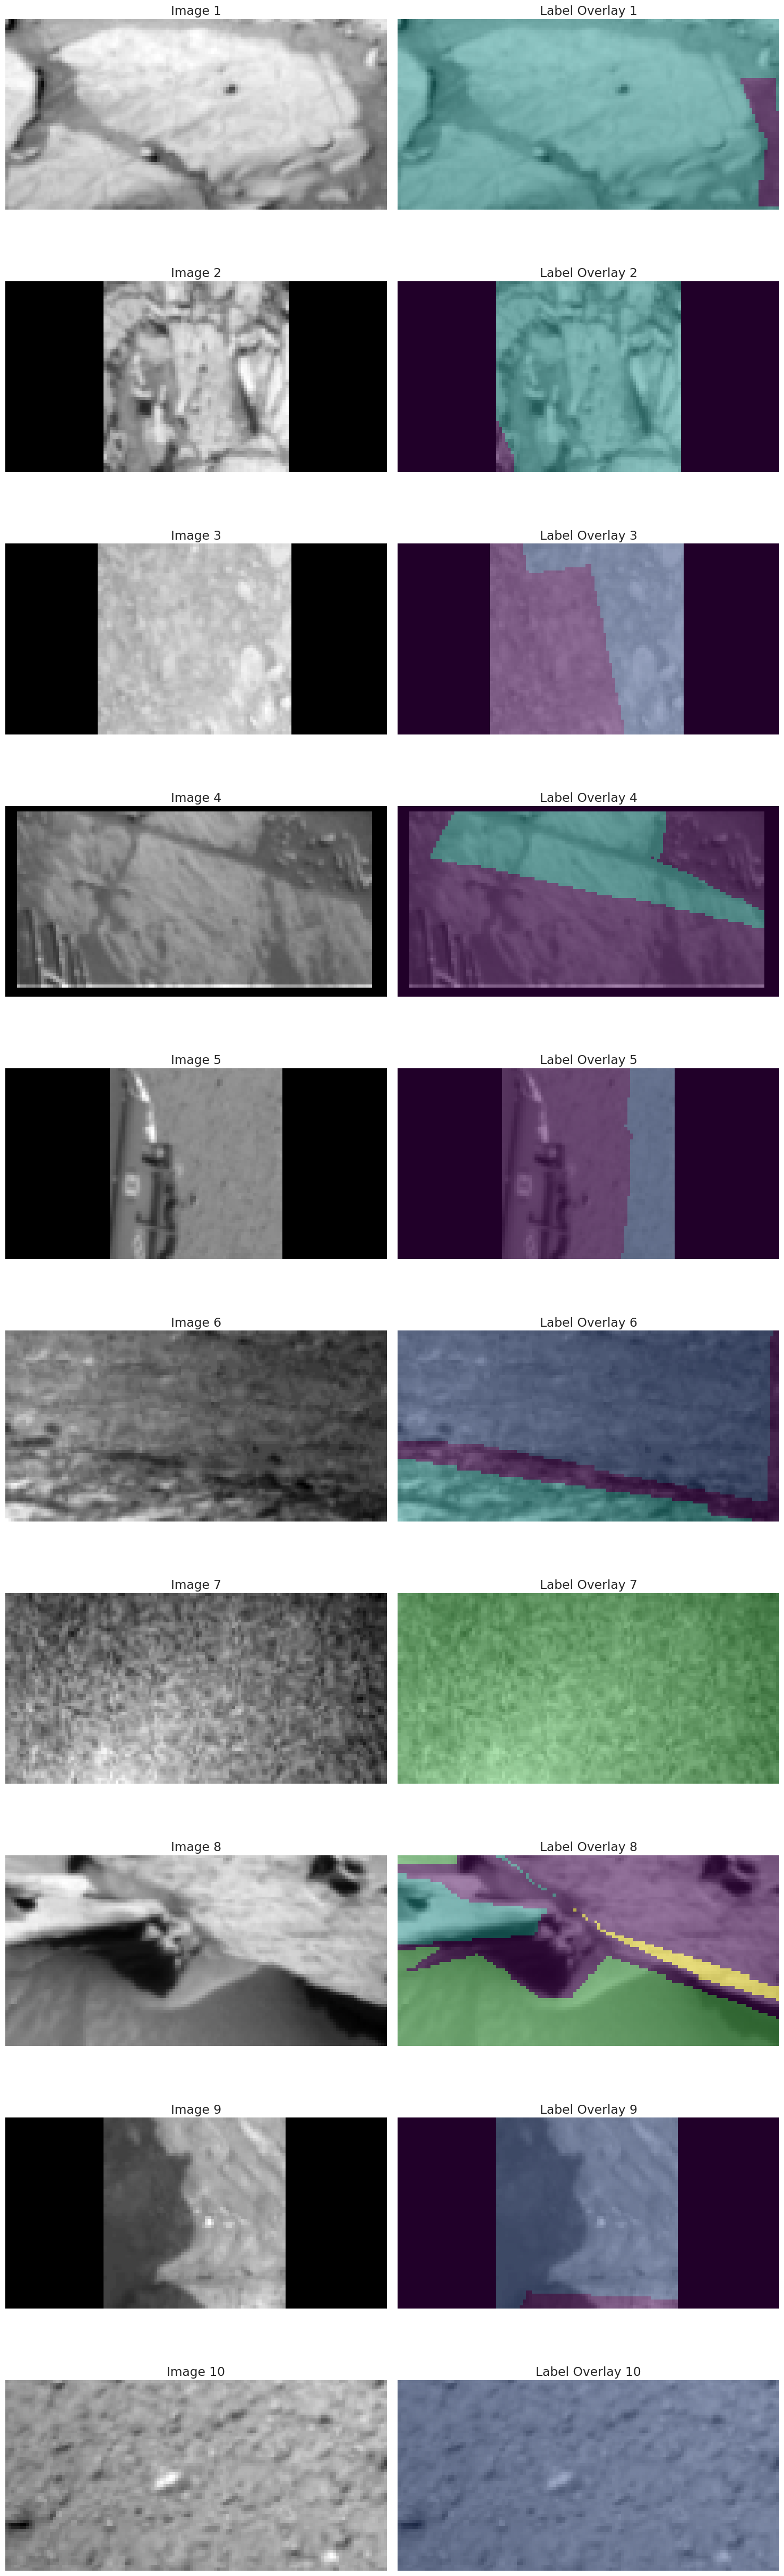

In [18]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3, class_names=None):
    """
    Display some image and label pairs from the dataset with label overlays.
    """
    plt.figure(figsize=(15, 5 * num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j].numpy().squeeze(), cmap='gray')  # Display grayscale image
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot image with label overlay
            plt.subplot(num_samples, 2, j*2 + 2)
            plt.imshow(images[j].numpy().squeeze(), cmap='gray')  # Display grayscale image as background
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label, alpha=0.5)  # Overlay label with transparency
            plt.title(f'Label Overlay {j+1}')
            plt.axis('off')

        # Add legend if class names are provided
        if class_names is not None:
            handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colormap(i), markersize=10)
                       for i in range(len(class_names))]
            plt.legend(handles, class_names, title="Class Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()
    plt.close()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=10)

##Build model

In [19]:
num_classes = len(np.unique(y_train))

In [21]:
def unet(input_shape, num_classes):

    def conv_block(x, filters):
        x = tfkl.Conv2D(filters, (3, 3), padding="same")(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.ReLU()(x)
        x = tfkl.Conv2D(filters, (3, 3), padding="same")(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.ReLU()(x)
        return x

    def encoder_block(x, filters):
        conv = conv_block(x, filters)
        pool = tfkl.MaxPooling2D((2, 2))(conv)
        return conv, pool

    def decoder_block(x, skip, filters):
        x = tfkl.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding="same")(x)
        x = tfkl.Concatenate()([x, skip])
        x = conv_block(x, filters)
        return x

    inputs = tfkl.Input(input_shape)

    enc1, pool1 = encoder_block(inputs, 32)
    enc2, pool2 = encoder_block(pool1, 64)
    enc3, pool3 = encoder_block(pool2, 128)
    enc4, pool4 = encoder_block(pool3, 256)

    bottleneck = conv_block(pool4, 512)

    dec4 = decoder_block(bottleneck, enc4, 256)
    dec3 = decoder_block(dec4, enc3, 128)
    dec2 = decoder_block(dec3, enc2, 64)
    dec1 = decoder_block(dec2, enc1, 32)

    outputs = tfkl.Conv2D(num_classes, (1, 1), activation="softmax")(dec1)

    model = Model(inputs, outputs)

    # Compilazione del modello con ottimizzazione e strategia di decay del learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    return model

# Esempio di utilizzo
model = unet(input_shape=(64, 128, 1), num_classes=num_classes)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, 64, 128, 32)  │          128 │ conv2d[0][0]        │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ re_lu (ReLU)           │ (None, 64, 128, 32)  │            0 │ batch_normalizatio… │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, 64, 128, 32)  │        9,248 │ re_lu[0][0]         │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1  │ (None, 64, 128, 32)  │          128 │ conv2d_1[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ re_lu_1 (ReLU)         │ (None, 64, 128, 32)  │            0 │ batch_normalizatio… │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 32)   │            0 │ re_lu_1[0][0]       │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_2 (Conv2D)      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d[0][0] │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_2  │ (None, 32, 64, 64)   │          256 │ conv2d_2[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ re_lu_2 (ReLU)         │ (None, 32, 64, 64)   │            0 │ batch_normalizatio… │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_3 (Conv2D)      │ (None, 32, 64, 64)   │       36,928 │ re_lu_2[0][0]       │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_3  │ (None, 32, 64, 64)   │          256 │ conv2d_3[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ re_lu_3 (ReLU)         │ (None, 32, 64, 64)   │            0 │ batch_normalizatio… │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_1        │ (None, 16, 32, 64)   │            0 │ re_lu_3[0][0]       │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_4 (Conv2D)      │ (None, 16, 32, 128)  │       73,856 │ max_pooling2d_1[0]… │    Y    │
├──────────────────────

 Total params: 7,771,429 (29.65 MB)

 Trainable params: 7,765,541 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

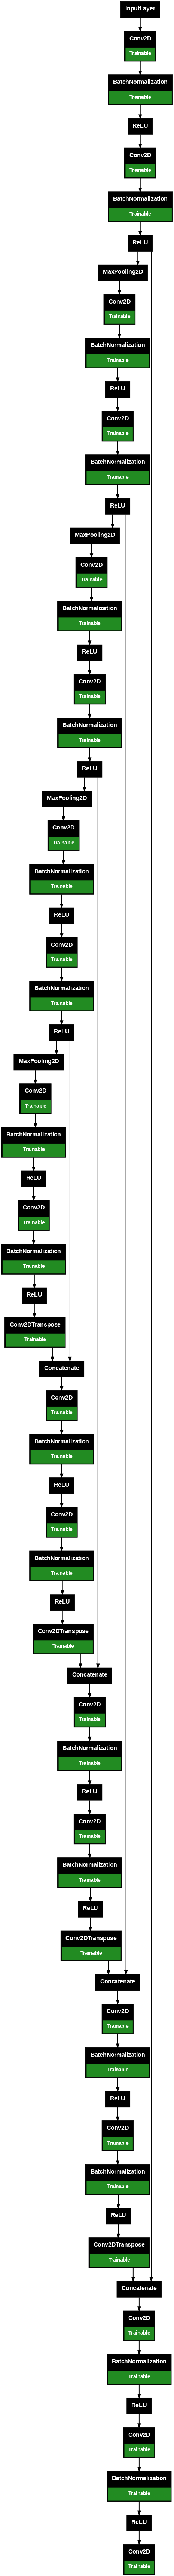

In [22]:
# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [23]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=5):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [24]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [25]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint(
    "Tom_best_model.keras",
    save_best_only=True,
    monitor="val_mean_io_u",
    mode="max"  # Assuming 'val_mean_io_u' is a metric you want to maximize
)

# Learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    monitor="val_loss",  # You can monitor 'val_loss' or another metric
    mode="min"
)

# Visualization callback
viz_callback = VizCallback(X_val[0], y_val[0])

# Add all callbacks to the list
callbacks = [early_stopping, model_checkpoint, reduce_lr, viz_callback]

In [26]:
# Initialize an array to hold the class counts
class_counts = np.zeros(5, dtype=int)  # Assuming 5 classes (0 to 4)

# Iterate through the dataset to count the pixels for each class
for image, label in train_dataset:
    # Flatten the label tensor and accumulate the pixel counts
    class_counts += np.bincount(label.numpy().flatten(), minlength=5)

# Compute the total number of pixels
total_pixels = np.sum(class_counts)

# Compute the inverse frequency class weights
class_weights = total_pixels / (len(class_counts) * class_counts)

# Create a dictionary with class indices as keys and the computed class weights as values
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Print the results
print("Class counts:", class_counts)
print("Class weights:", class_weights)

Class counts: [7776144 4183786 2947069 2215535   15130]
Class weights: {0: 0.44077537658767635, 1: 0.8192419019519641, 2: 1.1630310657809504, 3: 1.54704520578551, 4: 226.53884996695308}


## 🛠️ Train and Save the Model

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.4036 - loss: 1.6825 - mean_iou: 0.1237

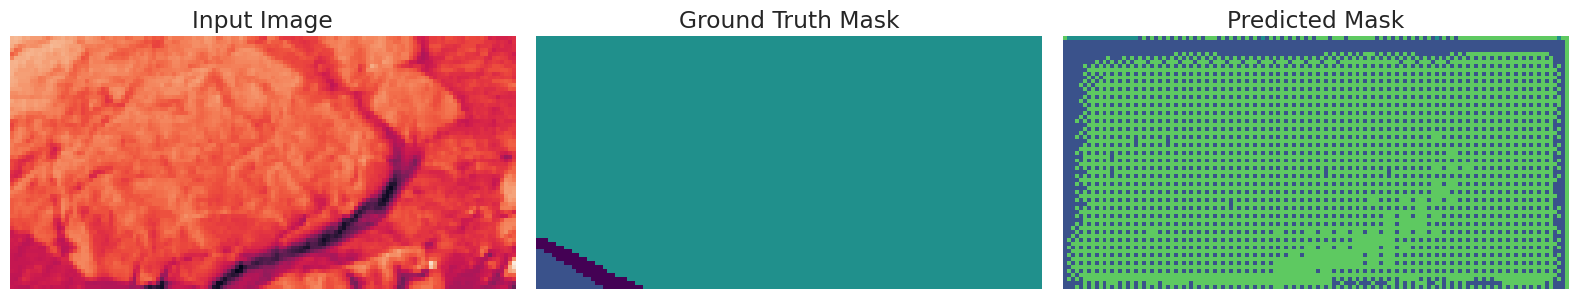

66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 398ms/step - accuracy: 0.4046 - loss: 1.6777 - mean_iou: 0.1241 - val_accuracy: 0.2321 - val_loss: 1.5025 - val_mean_iou: 0.1000 - learning_rate: 0.0010
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.4234 - loss: 1.4771 - mean_iou: 0.1237 - val_accuracy: 0.2030 - val_loss: 2.5117 - val_mean_iou: 0.0684 - learning_rate: 0.0010
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.4585 - loss: 1.4337 - mean_iou: 0.1567 - val_accuracy: 0.2031 - val_loss: 2.7466 - val_mean_iou: 0.0685 - learning_rate: 0.0010
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.4554 - loss: 1.3204 - mean_iou: 0.1535 - val_accuracy: 0.2030 - val_loss: 2.6785 - val_mean_iou: 0.0684 - learning_rate: 0.0010
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.4403 - loss: 1.3758 - mean_iou: 0.1391 - val_accuracy: 0.2025 - val_loss: 2.1706 - val_mean_iou: 0.0553 - learning_rate: 0.0010
Epoch 6/50
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 39m

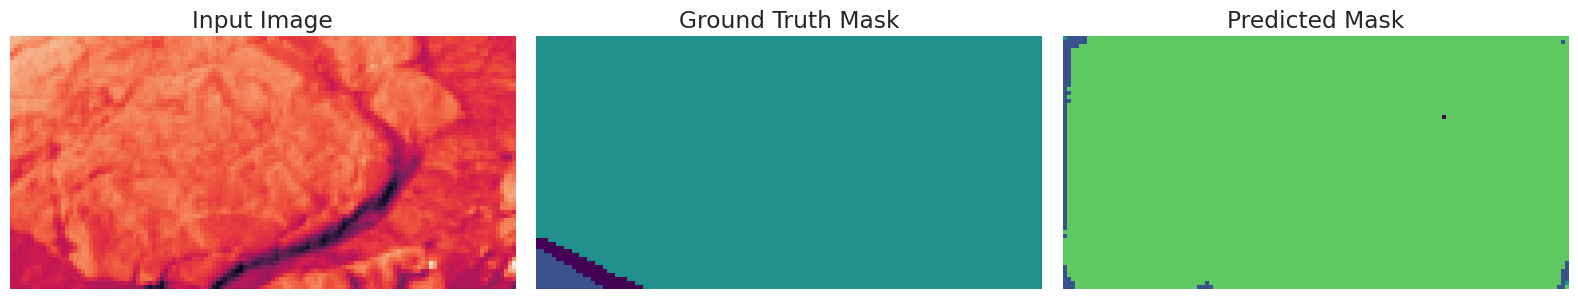

66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.4900 - loss: 1.1389 - mean_iou: 0.1810 - val_accuracy: 0.2059 - val_loss: 2.0307 - val_mean_iou: 0.0585 - learning_rate: 0.0010
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.5030 - loss: 1.2304 - mean_iou: 0.1989 - val_accuracy: 0.2099 - val_loss: 2.0945 - val_mean_iou: 0.0776 - learning_rate: 5.0000e-04
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5075 - loss: 1.2534 - mean_iou: 0.2016 - val_accuracy: 0.2291 - val_loss: 2.0237 - val_mean_iou: 0.0799 - learning_rate: 5.0000e-04
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.5013 - loss: 1.1740 - mean_iou: 0.1964 - val_accuracy: 0.3654 - val_loss: 1.4065 - val_mean_iou: 0.1779 - learning_rate: 5.0000e-04
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5086 - loss: 1.2525 - mean_iou: 0.2026 - val_accuracy: 0.2855 - val_loss: 1.7656 - val_mean_iou: 0.1244 - learning_rate: 5.0000e-04
Epoch 11/50
65/66 ━━━━━━━━━━━

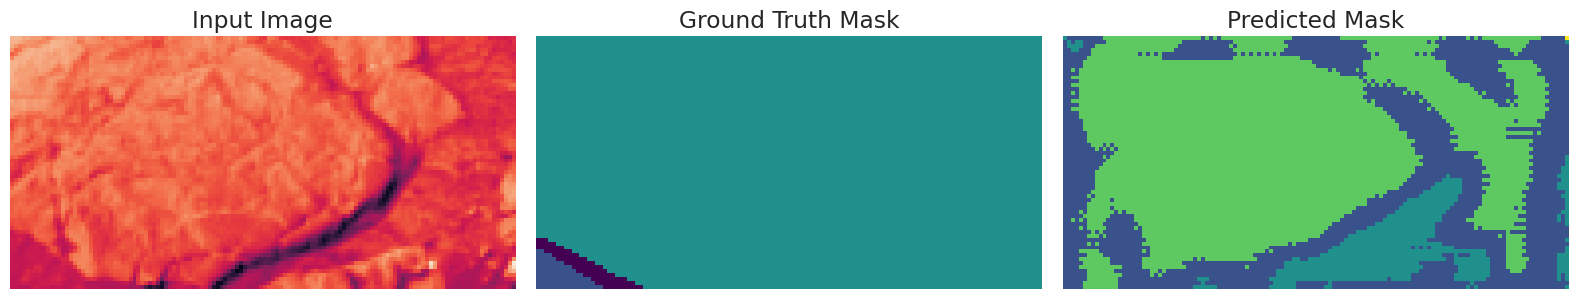

66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.4990 - loss: 1.1828 - mean_iou: 0.1916 - val_accuracy: 0.3845 - val_loss: 1.4086 - val_mean_iou: 0.2233 - learning_rate: 5.0000e-04
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5261 - loss: 1.1109 - mean_iou: 0.2169 - val_accuracy: 0.3552 - val_loss: 1.5653 - val_mean_iou: 0.1949 - learning_rate: 5.0000e-04
Epoch 13/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5299 - loss: 1.1065 - mean_iou: 0.2210 - val_accuracy: 0.3665 - val_loss: 1.4607 - val_mean_iou: 0.2196 - learning_rate: 5.0000e-04
Epoch 14/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5264 - loss: 1.1441 - mean_iou: 0.2189 - val_accuracy: 0.3385 - val_loss: 1.5723 - val_mean_iou: 0.1801 - learning_rate: 5.0000e-04
Epoch 15/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5440 - loss: 1.1524 - mean_iou: 0.2290 - val_accuracy: 0.3737 - val_loss: 1.4561 - val_mean_iou: 0.2147 - learning_rate: 2.5000e-04
Epoch 16/50
65/66 ━━━━

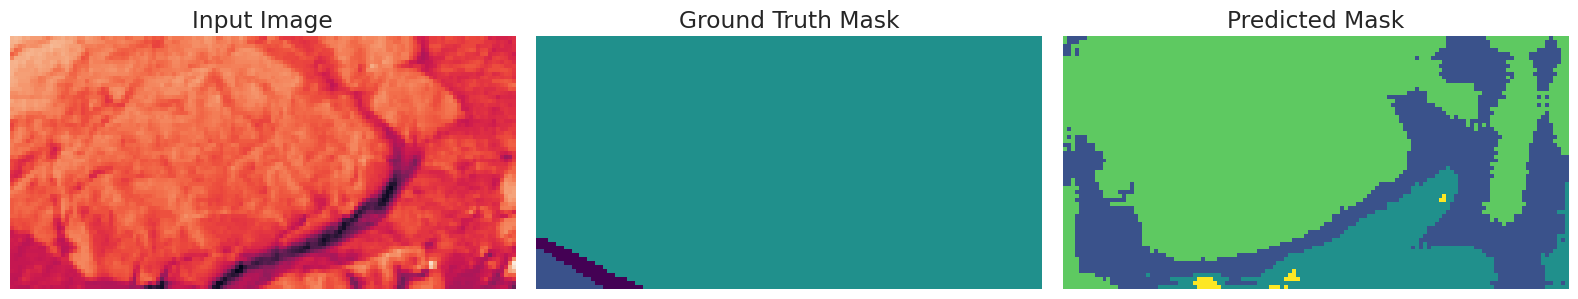

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.5342 - loss: 1.1061 - mean_iou: 0.2254 - val_accuracy: 0.3806 - val_loss: 1.3925 - val_mean_iou: 0.2278 - learning_rate: 2.5000e-04
Epoch 17/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5402 - loss: 1.0669 - mean_iou: 0.2319 - val_accuracy: 0.3800 - val_loss: 1.3998 - val_mean_iou: 0.2386 - learning_rate: 2.5000e-04
Epoch 18/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5416 - loss: 1.0510 - mean_iou: 0.2305 - val_accuracy: 0.3710 - val_loss: 1.4308 - val_mean_iou: 0.2181 - learning_rate: 2.5000e-04
Epoch 19/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5376 - loss: 1.1118 - mean_iou: 0.2316 - val_accuracy: 0.3724 - val_loss: 1.4422 - val_mean_iou: 0.2216 - learning_rate: 2.5000e-04
Final validation Mean Intersection Over Union: 23.86%


In [27]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1,
    class_weight=class_weights
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'model1.keras'
model.save(model_filename)

In [28]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

Model saved to model_241202_162436.keras


In [ ]:
del model

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [29]:
model = tfk.models.load_model('model1.keras', compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model_241202_162436.keras


In [30]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
Predictions shape: (10022, 64, 128)


In [31]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [32]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>